In [1]:
from IPython.core.display import display, HTML
import random
display(HTML("<style>.container { width:90% !important; }</style>"))

/tmp/ipykernel_65550/2154100854.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [16]:
import pandas as pd
from tqdm import tqdm

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

/beegfs/desy/user/buhmae/conda/envs/torch_113/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from functools import partial

import torch

from pyro.nn import AutoRegressiveNN, ConditionalAutoRegressiveNN

from pyro.distributions import constraints
from pyro.distributions.conditional import ConditionalTransformModule
from pyro.distributions.torch_transform import TransformModule
from pyro.distributions.util import copy_docs_from
from pyro.distributions.transforms import SplineCoupling
from pyro.distributions.transforms.spline import ConditionalSpline



import numpy as np
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
#from data_utils.data_loader import HDF5Dataset, MaxwellBatchLoader, MaxwellBatchLoaderFullyCond

from torch.nn.parallel import DistributedDataParallel as DDP
from torch.multiprocessing import Process

#import ML_models.models as models
#import ML_models.functions as functions
import time
import h5py

from custom_pyro import ConditionalAffineCouplingTanH

from pyro.nn import ConditionalDenseNN, DenseNN, ConditionalAutoRegressiveNN
import pyro.distributions as dist
import pyro.distributions.transforms as T
device = torch.device('cuda:0')

In [5]:
def compile_HybridTanH_model(num_blocks, num_inputs, num_cond_inputs, device):
    # the latent space distribution: choosing a 2-dim Gaussian
    base_dist = dist.Normal(torch.zeros(num_inputs).to(device), torch.ones(num_inputs).to(device))

    input_dim = num_inputs
    count_bins = 8
    transforms = []
    transforms2 = []
      
    input_dim = num_inputs
    split_dim = num_inputs//2
    param_dims1 = [input_dim-split_dim, input_dim-split_dim]
    param_dims2 = [input_dim * count_bins, input_dim * count_bins, input_dim * (count_bins - 1), input_dim * count_bins]

    torch.manual_seed(42)

    for i in range(num_blocks):
        

                    
        hypernet = ConditionalDenseNN(split_dim, num_cond_inputs, [input_dim*10, input_dim*10], param_dims1)
        ctf = ConditionalAffineCouplingTanH(split_dim, hypernet)
        transforms2.append(ctf)
        transforms.append(ctf)
        
        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)

        
        hypernet = ConditionalDenseNN(split_dim, num_cond_inputs, [input_dim*10, input_dim*10], param_dims1)
        ctf = ConditionalAffineCouplingTanH(split_dim, hypernet)
        transforms2.append(ctf)
        transforms.append(ctf)

        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)

        
        hypernet = ConditionalDenseNN(split_dim, num_cond_inputs, [input_dim*10, input_dim*10], param_dims1)
        ctf = ConditionalAffineCouplingTanH(split_dim, hypernet)
        transforms2.append(ctf)
        transforms.append(ctf)
        
        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)
        
        
        
        
        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)
        
        hypernet = DenseNN(num_cond_inputs, [input_dim*4, input_dim*4], param_dims2)
        ctf = T.ConditionalSpline(hypernet, input_dim, count_bins)
        transforms2.append(ctf)
        transforms.append(ctf)
        

        

        hypernet = ConditionalDenseNN(split_dim, num_cond_inputs, [input_dim*10, input_dim*10], param_dims1)
        ctf = ConditionalAffineCouplingTanH(split_dim, hypernet)
        transforms2.append(ctf)
        transforms.append(ctf)
        
        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)

        
        hypernet = ConditionalDenseNN(split_dim, num_cond_inputs, [input_dim*10, input_dim*10], param_dims1)
        ctf = ConditionalAffineCouplingTanH(split_dim, hypernet)
        transforms2.append(ctf)
        transforms.append(ctf)

        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)

        
        hypernet = ConditionalDenseNN(split_dim, num_cond_inputs, [input_dim*10, input_dim*10], param_dims1)
        ctf = ConditionalAffineCouplingTanH(split_dim, hypernet)
        transforms2.append(ctf)
        transforms.append(ctf)
        
        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)
        
        
        
        
        
    modules = nn.ModuleList(transforms2)

    flow_dist = dist.ConditionalTransformedDistribution(base_dist, transforms)

    return modules, flow_dist

In [7]:
model, distribution = compile_HybridTanH_model(num_blocks=10, 
                                           num_inputs=65, ### when 'condioning' on additional Esum, Nhits etc add them on as inputs rather than 
                                           num_cond_inputs=1, device=device)  # num_cond_inputs

In [12]:
default_params = {
    "batch_size" : 2048,
    "epochs" : 1000,
    "shuffle" : True,
}

In [13]:
kwargs = {}
params = {}
for param in default_params.keys():

    if param in kwargs.keys():
        params[param] = kwargs[param]
    else:
        params[param] = default_params[param]

In [14]:
path = '/beegfs/desy/user/akorol/data/calo-clouds/hdf5/high_granular_grid/train/10-90GeV_x36_grid_regular_524k_float32.hdf5'
energy = h5py.File(path, 'r')['energy'][:]
events = h5py.File(path, 'r')['events'][:]

num_points = (events[:][:, -1] > 0).sum(axis=1)
visible_energy = (events[:][:, -1]).sum(axis=1)

In [15]:
# calc cluster number and cluster energy per layer   - TAKES ABOUT 5 MINUTES, so just run once and save

# clusters_per_layer = [((events[:, 1, :] < i+1) & (events[:, 1, :] > i)).sum(axis=1) for i in range(30)]
# clusters_per_layer = np.vstack(clusters_per_layer)
# clusters_per_layer = np.moveaxis(clusters_per_layer, 0, -1)


# e_per_layer = []
# for i in tqdm(range(30)):
#     layer_mask = (events[:, 1, :] < i+1) & (events[:, 1, :] > i)
#     e_per_layer.append( (events[:, -1, :] * layer_mask).sum(axis=1) )
# e_per_layer = np.vstack(e_per_layer)
# e_per_layer = np.moveaxis(e_per_layer, 0, -1)

In [22]:
outdir = '/beegfs/desy/user/buhmae/6_PointCloudDiffusion/dataset/tmp/'

# save 
# np.save(outdir+'clusters_per_layer.npy', clusters_per_layer)
# np.save(outdir+'e_per_layer.npy', e_per_layer)

# load
clusters_per_layer = np.load(outdir+'clusters_per_layer.npy')
e_per_layer = np.load(outdir+'e_per_layer.npy')

In [34]:
# normalize cluster and energy per layer to [0,1]
clusters_per_layer = clusters_per_layer / clusters_per_layer.max(axis=1).reshape(len(clusters_per_layer), 1)
e_per_layer = e_per_layer / e_per_layer.max(axis=1).reshape(len(e_per_layer), 1)

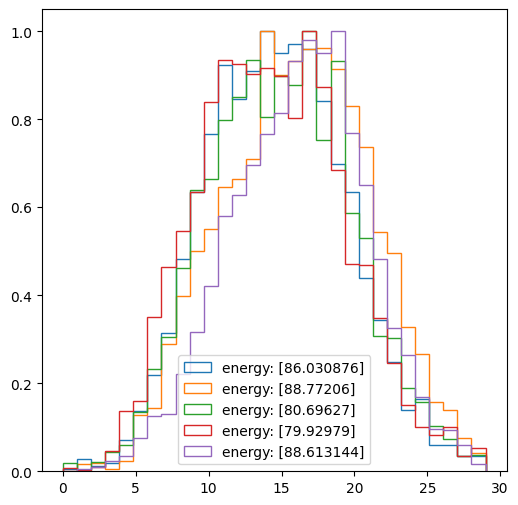

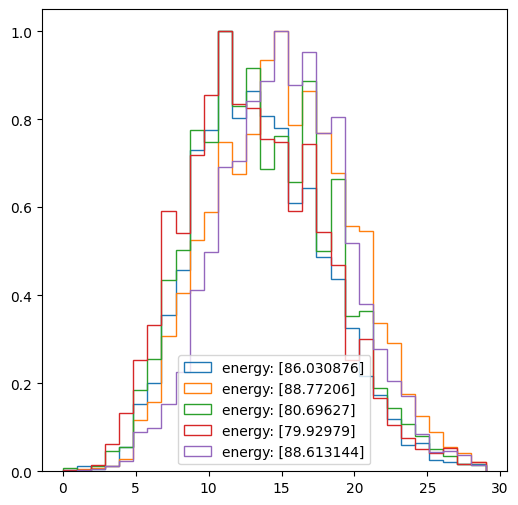

In [35]:
plt.figure(figsize=(6,6))
for i in range(500000, 500005):
    plt.hist(np.arange(30), weights=clusters_per_layer[i, :], label=f'energy: {energy[i]}', histtype='step', bins=30)
plt.legend()
plt.show()

plt.figure(figsize=(6,6))
for i in range(500000, 500000+5):
    plt.hist(np.arange(30), weights=e_per_layer[i, :], label=f'energy: {energy[i]}', histtype='step', bins=30)
plt.legend()
plt.show()

In [36]:
# center of gravity 

def get_cog(x,y,z,e):
    return np.sum((x * e), axis=1) / e.sum(axis=1), np.sum((y * e), axis=1) / e.sum(axis=1), np.sum((z * e), axis=1) / e.sum(axis=1)

cog = get_cog(
    events[:, 0],
    events[:, 1],
    events[:, 2],
    events[:, 3],
)


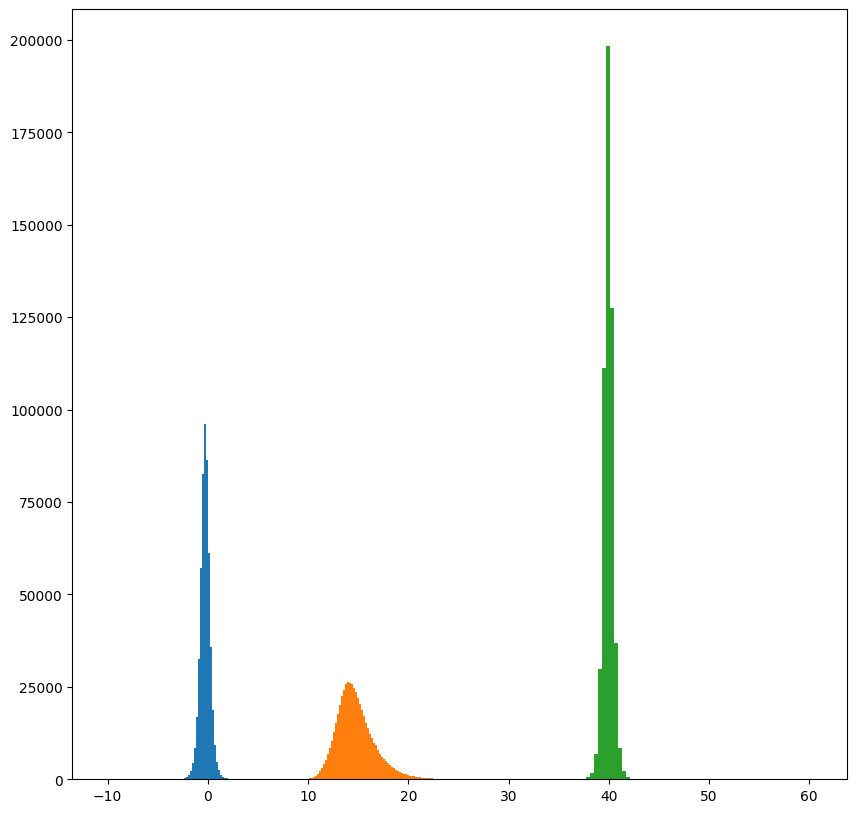

In [51]:
plt.figure(figsize=(10,10))
plt.hist(cog[0], bins=100, range=(-10, 10), label='x')
plt.hist(cog[1], bins=100)
plt.hist(cog[2], bins=100)
# plt.xlim(-10, 10)
plt.show()

In [49]:
(cog[1] / 2).mean()

7.375193

In [52]:
# clusters_per_layer = clusters_per_layer / 400

df = pd.DataFrame([])
df['energy'] = energy[:].reshape(-1)   # normalisation done in training loop
df['num_points'] = num_points / 5000
df['visible_energy'] = visible_energy / 2.5 

df['clusters_per_layer'] = clusters_per_layer.tolist()
df['e_per_layer'] = e_per_layer.tolist()

df['cog_x'] = cog[0]
df['cog_y'] = cog[1] / 2 - 7.5
df['cog_z'] = cog[2] - 40

In [60]:
dataset = torch.utils.data.TensorDataset(
    torch.tensor(df.energy.values), 
    torch.tensor(df.num_points.values), 
    torch.tensor(df.visible_energy.values),
    torch.tensor(df.cog_x.values),
    torch.tensor(df.cog_y.values),
    torch.tensor(df.cog_z.values),
    torch.tensor(df.clusters_per_layer),
    torch.tensor(df.e_per_layer),
    )

In [61]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=params["batch_size"], shuffle=params["shuffle"], pin_memory=True)


In [62]:
batch = next(iter(train_loader))

In [63]:
for item in batch:
    print(item.shape)

torch.Size([2048])
torch.Size([2048])
torch.Size([2048])
torch.Size([2048])
torch.Size([2048])
torch.Size([2048])
torch.Size([2048, 30])
torch.Size([2048, 30])


In [64]:
output_path = '/beegfs/desy/user/buhmae/6_PointCloudDiffusion/shower_flow/'
prefix = '220713_cog_e_layer_'
outpath = output_path + prefix

In [65]:
torch.manual_seed(123)

lr = 5e-5
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

# epoch_load = 550
# model.load_state_dict(torch.load(outpath+f'ShowerFlow_{epoch_load}.pth')['model'])
# optimizer.load_state_dict(torch.load(outpath+f'ShowerFlow_{epoch_load}.pth')['optimizer'])

epoch_start = 1   # default = 1
model.train()

ModuleList(
  (0): ConditionalAffineCouplingTanH(
    (nn): ConditionalDenseNN(
      (layers): ModuleList(
        (0): Linear(in_features=33, out_features=650, bias=True)
        (1): Linear(in_features=650, out_features=650, bias=True)
        (2): Linear(in_features=650, out_features=66, bias=True)
      )
      (f): ReLU()
    )
  )
  (1): ConditionalAffineCouplingTanH(
    (nn): ConditionalDenseNN(
      (layers): ModuleList(
        (0): Linear(in_features=33, out_features=650, bias=True)
        (1): Linear(in_features=650, out_features=650, bias=True)
        (2): Linear(in_features=650, out_features=66, bias=True)
      )
      (f): ReLU()
    )
  )
  (2): ConditionalAffineCouplingTanH(
    (nn): ConditionalDenseNN(
      (layers): ModuleList(
        (0): Linear(in_features=33, out_features=650, bias=True)
        (1): Linear(in_features=650, out_features=650, bias=True)
        (2): Linear(in_features=650, out_features=66, bias=True)
      )
      (f): ReLU()
    )
  )
  (3

In [72]:
losses = []
for epoch in range(epoch_start, params["epochs"]+1):
    input_list = []
    loss_list = []
#     for batch_idx, (mu, logvar, e, theta, e_sum) in enumerate(train_loader):
    for batch_idx, (energy, num_points, visible_energy, cog_x, cog_y, cog_z, clusters_per_layer, e_per_layer) in enumerate(tqdm(train_loader)):

        E_true = energy.view(-1, 1).to(device).float()
        energy_sum = visible_energy.view(-1,1).to(device).float()
        num_points = num_points.view(-1, 1).to(device).float()
        cog_x = cog_x.view(-1, 1).to(device).float()
        cog_y = cog_y.view(-1, 1).to(device).float()
        cog_z = cog_z.view(-1, 1).to(device).float()
        clusters_per_layer = clusters_per_layer.to(device).float()
        e_per_layer = e_per_layer.to(device).float()
   
        # normalise conditional labels
        E_true = (E_true/100).float()

        input_data = torch.cat((energy_sum, num_points, cog_x, cog_y, cog_z, clusters_per_layer, e_per_layer), 1)   #### input data structure required for network with additional features in latent space (e.g. Esum)
        
        #input_data = torch.cat((z), 1)
        #input_data = z

        optimizer.zero_grad()

        # try to add context for conditioning by concatenating 
        context = E_true
        #print(theta_true.size())
        
        #nll = -distribution.condition(E_true).log_prob(input_data) ## solution   # does this work, or do need spearate .condition for each label?
        
        # if np.any(np.isnan(input_data.clone().detach().cpu().numpy())) == True:
        #     print('Nans in the training data!')
            
        #### check if any of the weights are nans
        if torch.stack([torch.isnan(p).any() for p in model.parameters()]).any():
            print('Weights are nan!')
            # load recent model
            model.load_state_dict(torch.load(outpath+f'ShowerFlow_latest.pth')['model'])
            optimizer.load_state_dict(torch.load(outpath+f'ShowerFlow_latest.pth')['optimizer'])
            # print(f'model from {epoch-3} epoch reloaded')
            print(f'latest model reloaded')
                           
        nll = -distribution.condition(context).log_prob(input_data)
        loss = nll.mean()
        #print(loss.item())
        loss.backward()

        optimizer.step() 

        distribution.clear_cache()
        
        loss_list.append(loss.item())
        # input_list.append(input_data.detach().cpu().numpy())

    print(epoch, np.mean(loss_list))
    losses.append(np.mean(loss_list))

    # save best model based on loss
    if epoch == 1:
        best_loss = np.mean(loss_list)
    if np.mean(loss_list) <= best_loss:
        best_loss = np.mean(loss_list)
        torch.save(
            {'model': model.state_dict(),
             'optimizer': optimizer.state_dict(),},
            outpath+f'ShowerFlow_best.pth'
        )
        print('best model saved')
    #############################
    # Log to COMET ML
    #############################
    torch.save(
        {'model': model.state_dict(),
         'optimizer': optimizer.state_dict(),},
        outpath+f'ShowerFlow_latest.pth'
    )

    if epoch%10 == 0:
        torch.save(
            {'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),},
            outpath+f'ShowerFlow_{epoch}.pth'
        )
        # print('model saved')



100%|██████████| 257/257 [01:04<00:00,  4.01it/s]


1 -138.48949049419002
best model saved


100%|██████████| 257/257 [01:02<00:00,  4.08it/s]


2 -138.69479055441772
best model saved


100%|██████████| 257/257 [00:54<00:00,  4.74it/s]


3 -138.84564060552574
best model saved


100%|██████████| 257/257 [00:56<00:00,  4.52it/s]


4 -139.10012906441892
best model saved


100%|██████████| 257/257 [01:02<00:00,  4.14it/s]


5 -138.77199866150139


100%|██████████| 257/257 [01:00<00:00,  4.25it/s]


6 -138.92289864506702


100%|██████████| 257/257 [01:04<00:00,  4.00it/s]


7 -139.07895295258163


100%|██████████| 257/257 [01:03<00:00,  4.04it/s]


8 -139.0520158463415


100%|██████████| 257/257 [01:05<00:00,  3.95it/s]


9 -139.1325370105788
best model saved


100%|██████████| 257/257 [01:05<00:00,  3.92it/s]


10 -138.9423479607133


100%|██████████| 257/257 [01:05<00:00,  3.90it/s]


11 -139.18790634689628
best model saved


 22%|██▏       | 57/257 [00:13<00:42,  4.70it/s]